<a href="https://colab.research.google.com/github/peeyushsinghal/image-segmentation/blob/main/road_predict_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### Prediction Strategy
The image size of the satellite image is 1500 x 1500 x 3, making it a very big image. Ideal training of networks is done on image sizes which are in multiple of 2 i.e. 64,128,256,512,1024. However, it was seen that resizing the original image size to lower sizes, degrades the resolution a lot. Further training of the model was done using cropped images of size 512 x 512 x 3.

This leads us to the strategy where the original image was divided into tiles. 

1.   Original Image was divided into tiles : number of tiles = [ceil (original image size / model image size)]^2, which 9 tiles
2.   The image was equally divivded for 9 tiles giving each tile size of 500 x 500
3.   Each tile was then resize to 512 x 512 x 3 so that it can then become an input for the model
4.   Prediction was done for each time - giving us 9 ouputs of 512x 512 x 1. 
5.   Each predicted image was then resized to 500 x 500 x 1
6.   The predicted image was reconstructed using the predicted output

This strategy provided far better results viz a viz a pure resize and predict startegy








**The file is written in .ipynb but .py can be created out of it **

---



### Mounting Google Drive

For one  time use - Uncomment the function, for repeated "Run Alls"

In [2]:
# from google.colab import drive
# # drive.flush_and_unmount()
# # drive.mount('/content/gdrive',force_remount=True)

# drive.mount('/content/gdrive')

### Importing Libraries

In [3]:
# importing libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt # for plotting
import matplotlib.image as mpimg 
import random # for generating random numbers and samples

import tensorflow as tf
import math # to execute math operations for image processing
from matplotlib import cm # for storing predicted image
from sklearn.metrics import jaccard_score, accuracy_score, precision_score, recall_score # Evaluation metrics
import pandas as pd

### Defining Constants

In [4]:
#### CONSTANTS

SEED = 42 # for reproducing results
base_dir = '/content/gdrive/MyDrive/image-segment-dataset/massachusetts-roads-dataset/road_segmentation_ideal' # gdrive
ORIGINAL_IMG_SIZE = 1500
MOBILENET_IMG_SIZE = 512
RESUNET_IMG_SIZE = 512
THRESHOLD = 0.5 #used for setting values in predicted image

In [5]:
np.random.seed(SEED)

##  Functions
These are divided into following set of functions

**Data related**

1.   Raw Data related functions
2.   Visualization Functions

**Process related**

1.   Load Model
2.   Predict for single test image
3.   Evaluate for single test image, corresponding ground truth



### Data Related : Raw Data related functions
Helper functions to 

*   Get all files in a directory based on extension type
*   Get full path of files
*   Get common files between two directories, ratio of common files to files in directory 1 and directory 2
*   Get files when the file index is provided
*   Split the files into training and validation based on split ratio


In [6]:
## Dataset related Helper functions

def return_all_file_names(path,extn=".png"):
  '''function to return all file names in directory in a list'''
  all_files =[]
  for file in os.listdir(path):
      if file.endswith(extn):
        all_files.append(file)
  return all_files

def get_common_file_names(dir1,dir2):
  '''funtion to get the common file names between two directories, ratio of common files to files in directory 1 and directory 2'''
  dir1_file_names = return_all_file_names(dir1)
  dir2_file_names = return_all_file_names(dir2)
  common_file_names = list(set(dir1_file_names)&set(dir2_file_names))
  ratio_dir1 = round(len(common_file_names)/len(dir1_file_names),2)
  ratio_dir2 = round(len(common_file_names)/len(dir2_file_names),2)
  return common_file_names,ratio_dir1,ratio_dir2

def get_file_paths(file_names,dir):
  ''' gets direct files paths if file names and directory is provided '''
  file_path = []
  for fname in file_names:
    file_path.append(os.path.join(dir,fname))
  return file_path

def get_index_filepath(list_index,filepath):
  '''function  provides a list of file path, if list of indices of file is provided '''
  list_filepath =[]
  for idx in list_index:
    list_filepath.append(filepath[idx])
  return (list_filepath)

In [7]:
def load_testing_data_file_path(path):
  '''
  Loads file paths of Testing Data (images and corresponding segmentation masks) from a directory path.
  '''
  test_dir = os.path.join(path,'testing') # base_dir is a global variable
  test_input_dir = os.path.join(test_dir,'input') # Images are kept 3 channel
  test_output_dir = os.path.join(test_dir,'output') # Corresponding Segmentatation Mask are kept here

  test_input_file_names = return_all_file_names(test_input_dir,extn=".png")
  test_output_file_names = return_all_file_names(test_output_dir,extn=".png")

  # assert set(test_input_file_names) == set(test_output_file_names), " The files in input and output directory for testing is not same"

  test_x = sorted(get_file_paths(test_input_file_names,test_input_dir))
  test_y = sorted(get_file_paths(test_output_file_names,test_output_dir))

  return (test_x,test_y)

In [8]:
def read_input_image(path):
  '''
  reads the file from a direct path, normalizes it
  provided output in WxHx3 
  '''
  x = cv2.imread(path, cv2.IMREAD_COLOR)
  x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
  # x = cv2.resize(x, (ORIGINAL_IMG_SIZE, ORIGINAL_IMG_SIZE))
  x = x/255.0
  return x

def read_output_image(path):
  '''
  reads the file from a direct path, normalizes it
  provided output in WxHx1
  '''
  x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  # x = cv2.resize(x, (ORIGINAL_IMG_SIZE, ORIGINAL_IMG_SIZE))
  x = np.expand_dims(x, axis=-1)
  x = x/255.0
  return x



In [9]:
def load_ground_truth(file_paths):
  '''
  loads ground truth images from a list of file paths
  '''
  file_paths = sorted(file_paths)
  # print([x.split("/")[-1] for x in file_paths])
  list_gt_images = []
  for fname in file_paths:
    img=mpimg.imread(fname) # provides output in 2D
    list_gt_images.append(img)
  ground_truth = np.array(list_gt_images) # type conversion
  return (ground_truth)

### Data Related : Visualization Functions

In [10]:
def shape_output_for_presentation(output_img):
  ''' transforms output image so that it can be used for 
  concatenating with 3 channel imput image'''
  output_img = np.squeeze(output_img)
  output_img = [output_img, output_img, output_img]
  output_img = np.transpose(output_img, (1, 2, 0))
  return output_img


def show_test_samples(list_input_image,list_output_image,num_sample=1):
  '''
  Shows num_samples (default 1) samples of the dataset
  '''
  print(f"Displaying {num_sample} samples")
  list_input_image = sorted(list_input_image)
  list_output_image = sorted(list_output_image)
  assert len(list_input_image) >= num_sample, f" The number of samples is greater than number of test images :{len(list_input_image)}" 

  list_random_index = random.sample(range(0,len(list_input_image)),num_sample) # randomly picking up the files

  samples_input_image = get_index_filepath(list_random_index,list_input_image)
  samples_output_image = get_index_filepath(list_random_index,list_output_image)

  # fig=plt.figure(figsize=(16, 16))
  # counter = 1
  for i, (x, y) in enumerate(zip(samples_input_image, samples_output_image)):
    file_name = x.split("/")[-1]
    x = read_input_image(x)
    y = read_output_image(y)
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [x, white_line, shape_output_for_presentation(y)]

    image = np.concatenate(all_images, axis=1)

    fig = plt.figure(figsize=(12, 12))
    plt.axis('off')
    a = fig.add_subplot(1, 1, 1)
    plt.title(str(file_name))
    plt.imshow(image)
    # counter = counter +2
    plt.show()

### Process Related Functions
1.   Load Model
2.   Predict for single test image
3.   Evaluate for single test image, corresponding ground truth


In [11]:
def load_model(model_selected = 'unet_pretrained_mobilenetv2'):
  ''' loads the model selected and returns loaded model object'''
  
  model_dir = os.path.join(base_dir,'models') # models directory 
  model_save_dir = os.path.join(model_dir,str(model_selected)) # directory for the selected model
  model_final_save_dir = os.path.join(model_save_dir,'model_save') # final save directory for the selected model

  try:
    if os.path.exists(model_dir) or os.path.exists(model_save_dir) or os.path.exists(model_final_save_dir):
      print("Model Directories are accessible")
  except:
    print("Model Directories are not present / accessible")

  custom_objects ={'dice_loss':tf.keras.losses,'metric_iou':tf.keras.metrics, 'dice_coef': tf.keras.metrics}
  loaded_model = tf.keras.models.load_model(model_final_save_dir,custom_objects=custom_objects)
  # # loaded_model = tf.keras.models.load_model(model_final_save_dir,custom_objects=custom_objects,compile=False) # compile = False, does not make model eligible for further fit and evaluate

  return loaded_model

In [12]:
def predict_loaded_model(x, loaded_model,
                         model_img_size = 512,original_img_size=1500, 
                         threshold = 0.5
                         ):
  '''
  This function aligns to the prediction strategy. Take in single file and loaded model
  Returns predicted output of the image having the same width and height as original one.

  1.   Original Image was divided into tiles : number of tiles = [ceil (original image size / model image size)]^2, which gives 9 tiles (split)
  2.   The image was equally divivded for 9 tiles giving each tile size of 500 x 500
  3.   Each tile was then resize to 512 x 512 x 3 so that it can then become an input for the model
  4.   Prediction was done for each time - giving us 9 ouputs of 512x 512 x 1. 
  5.   Each predicted image was then resized to 500 x 500 x 1
  6.   The predicted image was reconstructed using the predicted output
  '''
  
  # x = read_input_image(test_x)

  split = math.ceil(original_img_size / model_img_size) # Number of split (tile size in one dimension)
  
  exact_split = True
  if original_img_size % model_img_size != 0:
    exact_split = False

  split_size = int(original_img_size / split) # tile size or split size
  assert (original_img_size % split) == 0, "Please change the model image size, accepted model image sizes are 128,256,512,1024"

  tiles = [x[w:w+split_size,h:h+split_size] for w in range(0,original_img_size,split_size) for h in range(0,original_img_size,split_size)]
  # print (f" The image is split into {len(tiles)} parts")

  rows = int(math.sqrt(len(tiles)))
  columns = int(math.sqrt(len(tiles)))
  
  tile_counter = 0
  image_row = []
  for row in range(0,rows):
    list_col = []
    for col in range(0,columns):
      img = tiles[tile_counter]
      tile_counter += 1
      img = cv2.resize(img, (model_img_size, model_img_size),
                       interpolation= cv2.INTER_LINEAR) # increase in size to model size

      ''' model.predict happens here'''
      img = loaded_model.predict(np.expand_dims(img, axis=0))[0] > threshold
      # print("shape after predict",img.shape)

      img = cv2.resize(np.float32(img), (split_size, split_size),
                       interpolation= cv2.INTER_AREA) # shinking in size to image split size
      # print("shape after reduction in size",img.shape)
      
      list_col.append(img)           
    all_row_imgs = np.concatenate(list_col, axis=1)
    image_row.append(all_row_imgs)
  y_pred = np.concatenate(image_row, axis=0)


  return y_pred


In [13]:
def store_predicted_images(list_test_pred_file_names_and_images,submission_dir):
  '''
  stores predicted image ouput in the submission file, 
  provided with a list of predicted outputs and file names
  '''
  for test_pred_file_name_and_image in list_test_pred_file_names_and_images:
    fname = test_pred_file_name_and_image[0].split("/")[-1]
    y_pred = test_pred_file_name_and_image[1]
    fname = os.path.join(submission_dir,fname)
    plt.imsave(fname, y_pred, cmap=cm.gray)

# def store_predicted_images_dict(dict_test_pred_file_names_and_images,submission_dir):
#   for test_pred_file_name_and_image in list_test_pred_file_names_and_images:
#     fname = test_pred_file_name_and_image[0].split("/")[-1]
#     y_pred = test_pred_file_name_and_image[1]
#     fname = os.path.join(submission_dir,fname)
#     plt.imsave(fname, y_pred, cmap=cm.gray)

## `Main function`

In [14]:
def  prediction_pipeline_orchestrator(model_selected ='unet_pretrained_mobilenetv2'):
  print("\n Model Prediction and Evaluation Pipeline Starts")
  print("Model Selected:",model_selected )

  #---------------------------------------------------------------#
  ### Loading test dataset (file paths) 
  (test_x,test_y) = load_testing_data_file_path(base_dir)

  #---------------------------------------------------------------#
  ### Seeing samples of train and validate dataset (which have file paths) (uncomment to see)
  show_test_samples(test_x,test_y,num_sample=1)

  #---------------------------------------------------------------#
  ### Loading Model

  loaded_model = load_model(model_selected = 'unet_pretrained_mobilenetv2')
  print(f"\nModel {model_selected} loaded successfully")

  #---------------------------------------------------------------#
  #### Show the model architecture (uncomment to see)
  loaded_model.summary()  
  #---------------------------------------------------------------#
  #### Predict model on the dataset
  print("\n Model Prediction Starts")
   
  list_y_pred =[] # This list would be later used for storing predictions
  for i, (x, y) in enumerate(zip(test_x, test_y)):
  # for i, (x, y) in enumerate(zip(test_x[:1], test_y[:1])): # This is for testing

    file_name = x.split("/")[-1]

    x = read_input_image(x)
    y = read_output_image(y)
    y_pred = predict_loaded_model(x, loaded_model = loaded_model,
                                  model_img_size = MOBILENET_IMG_SIZE ,
                                  original_img_size=ORIGINAL_IMG_SIZE,
                                  threshold = THRESHOLD)
    
    list_y_pred.append([file_name,y_pred]) # This list would be later used for storing predictions
    ##--------------------------------------#
    ## Printing all images
    white_line = np.ones((x.shape[0],10,3))
    all_images = [
        x, white_line,shape_output_for_presentation(y), white_line,
        shape_output_for_presentation(y_pred)]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    plt.axis('off')
    plt.title(str(file_name))
    imgplot = plt.imshow(image)

  #----------------------------------------#
  ### creating submission directory 

  submission_dir_name = "submission_"+str(model_selected)
  submission_dir = os.path.join(base_dir,"submission_"+str(model_selected))
  if not os.path.exists(submission_dir):
    try:
      os.makedirs(submission_dir)
    except:
      print("Problem in creating submission directory")

  #---------------------------------------#
  ### Storing Predicted images

  try:
    store_predicted_images(list_y_pred,submission_dir)
  except:
    print("Problem storing predicted images in submission directory")
  

  print("Prediction part of prediction_pipeline is complete")

  #---------------------------------------#
  ### Evaluate model between predicted images and ground truth output images
  print("\n Model Evaluation Starts")

  ### getting all the ground truth images
  ground_truth = load_ground_truth(test_y) # this gives array of images sorted by image name
  ground_truth = ground_truth.astype(int) # making sure all elements are integers

  ## sorting list_y_pred (list of list) based on file name,the list includes file name and predicted image
  list_y_pred.sort(key = lambda list_y_pred: list_y_pred[0])

  predicted_images = []
  for item in list_y_pred:
    fname = item [0]
    image = item [1]
    predicted_images.append(image)
  predicted_images = np.array(predicted_images)
  predicted_images= predicted_images.astype(int) # making sure all elements are integers

  list_evaluation_metric =[]
  for i in range (0,len(ground_truth)):
    iou_road_img = jaccard_score(ground_truth[i].flatten(),predicted_images[i].flatten())# checked sklearn metric doc, it shows iou for 1 (positive label)
    accuracy_img = accuracy_score(ground_truth[i].flatten(),predicted_images[i].flatten())
    precision_img = precision_score(ground_truth[i].flatten(),predicted_images[i].flatten())
    recall_img = recall_score(ground_truth[i].flatten(),predicted_images[i].flatten())
    list_evaluation_metric.append([str(test_y[i].split("/")[-1]),iou_road_img,accuracy_img, precision_img,recall_img])
  
  print(np.array(list_evaluation_metric))

  df_submission = pd.DataFrame(list_evaluation_metric, columns=['File_Name', 'IoU_Road','Accuracy','Precision','Recall'])

  submission_file_name="submission_"+str(model_selected)+".csv"
  try:
    df_submission.to_csv(os.path.join(submission_dir,submission_file_name),index=False)
  except:
    print("Problem in saving submission file")

  print("evaluation part of prediction_pipeline is complete")

 
  print("\n Model Prediction and Evaluation Pipeline Completed")



 Model Prediction and Evaluation Pipeline Starts
Model Selected: resunet
Displaying 1 samples


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


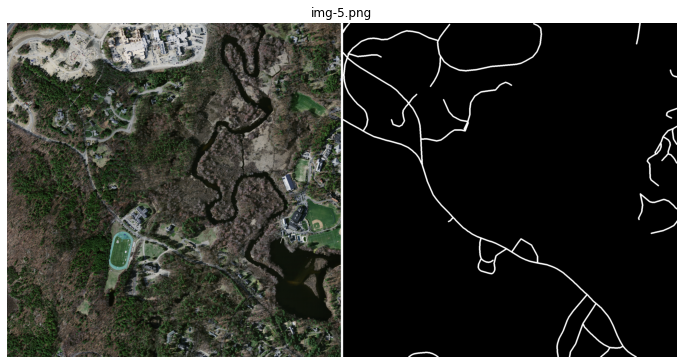

Model Directories are accessible

Model resunet loaded successfully
Model: "unet_pretrained_mobilenetv2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 256, 256, 16) 432         input_image[0][0]                
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 256, 256, 16) 64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 256, 256, 16) 0           bn_Conv1[0][0]                   
____

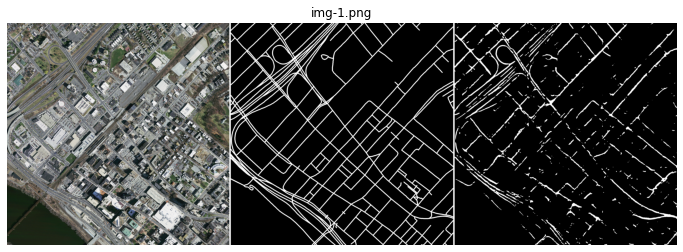

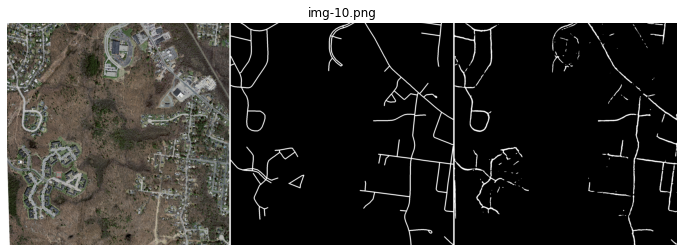

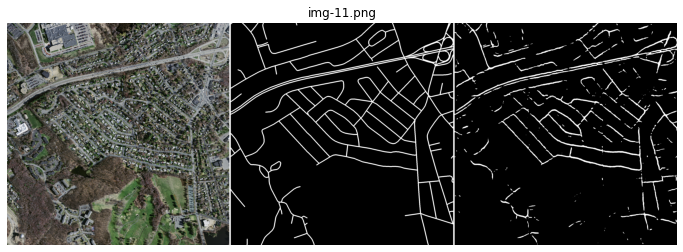

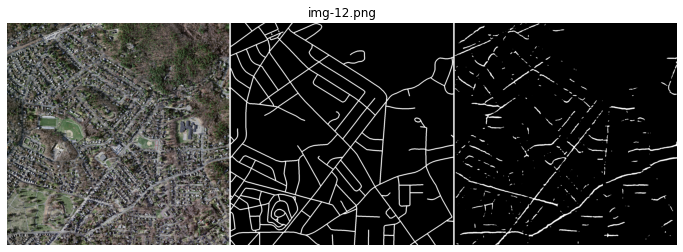

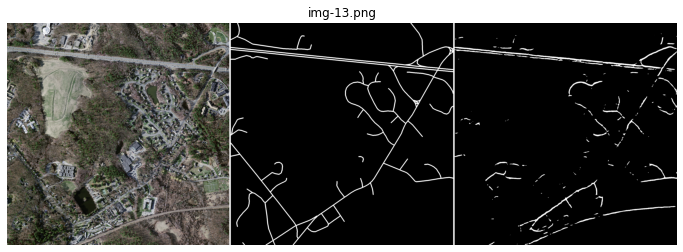

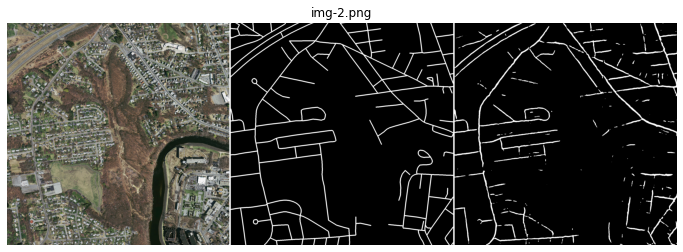

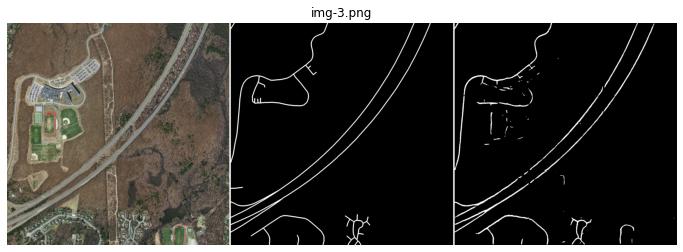

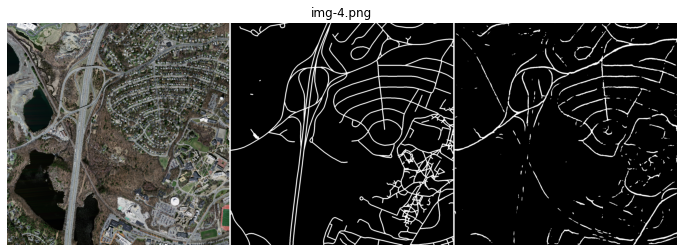

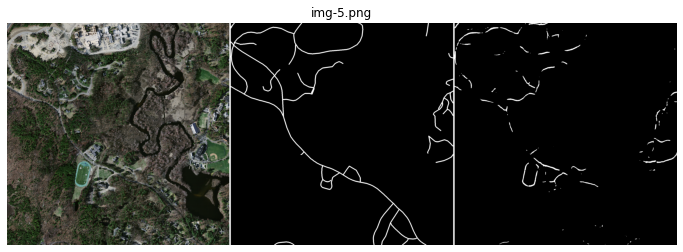

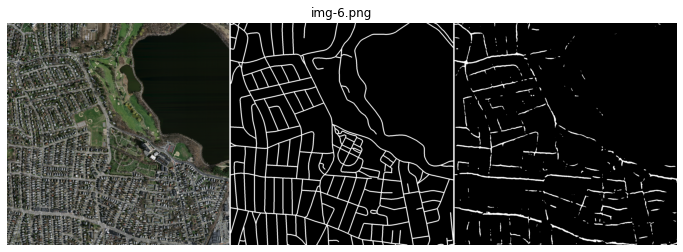

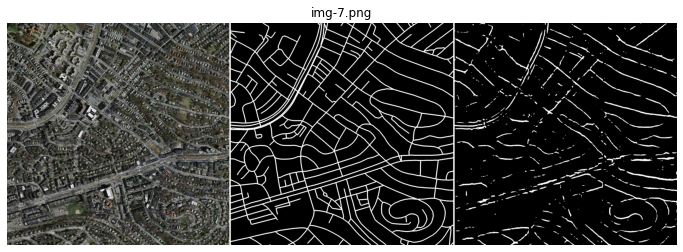

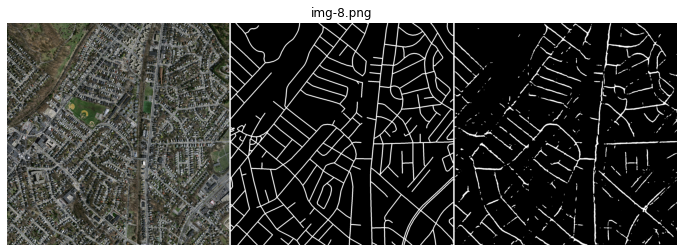

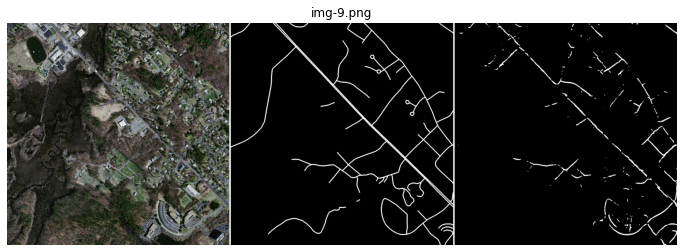

In [15]:
if __name__ == '__main__':
  # prediction_pipeline_orchestrator(model_selected ='unet_pretrained_mobilenetv2')
  prediction_pipeline_orchestrator(model_selected ='resunet')


### Test

In [16]:
# # Version 2
## Splits the image and merges it back

# (test_x,test_y) = load_testing_data_file_path(base_dir)

# print(test_x[0], test_y[0])

# for i, (x, y) in enumerate(zip(test_x[:1], test_y[:1])):
#   x = read_input_image(x)
#   y = read_output_image(y)
#   MODEL_IMG_SIZE = MOBILENET_IMG_SIZE
#   # MODEL_IMG_SIZE = 64
#   split = math.ceil(ORIGINAL_IMG_SIZE / MODEL_IMG_SIZE)

#   exact_split = True
#   if ORIGINAL_IMG_SIZE % MODEL_IMG_SIZE != 0:
#     exact_split = False

#   split_size = int(ORIGINAL_IMG_SIZE / split)
#   assert (ORIGINAL_IMG_SIZE % split) == 0, "Please change the model image size, accepted model image sizes are 128,256,512,1024"

#   tiles = [x[w:w+split_size,h:h+split_size] for w in range(0,ORIGINAL_IMG_SIZE,split_size) for h in range(0,ORIGINAL_IMG_SIZE,split_size)]
#   print ("Number of tiles ", len(tiles))

#   rows = int(math.sqrt(len(tiles)))
#   columns = int(math.sqrt(len(tiles)))
  
#   tile_counter = 0
#   blank_image = np.zeros((ORIGINAL_IMG_SIZE,ORIGINAL_IMG_SIZE, 3), dtype = int) # change 3 to 1
#   print(blank_image.shape)
#   image_row = []
#   for row in range(0,rows):
#     list_col = []
#     for col in range(0,columns):
#       img = tiles[tile_counter]
#       tile_counter += 1
#       img = cv2.resize(img, (MODEL_IMG_SIZE, MODEL_IMG_SIZE),interpolation= cv2.INTER_LINEAR) # increase in size
#       ''' model.predict goes here'''
#       img = cv2.resize(img, (split_size, split_size),interpolation= cv2.INTER_AREA) # shinking in size
#       list_col.append(img)           
#       # print("img shape",img.shape )
#     all_row_imgs = np.concatenate(list_col, axis=1)
#     image_row.append(all_row_imgs)
#   reconstructed = np.concatenate(image_row, axis=0)

#   fig = plt.figure(figsize=(12, 12))
#   a = fig.add_subplot(1, 1, 1)
#   imgplot = plt.imshow(reconstructed)
#   #     # blank_image [r*split_size:(r+1)*split_size,c*split_size:(c+1)*split_size,:] = img
#   #     # list_col.append(img)
#   # image_row  
#   #   # image.append(list_col)
#   # # image = np.array(image)
#   # print(blank_image.shape)
#   # print("non zero",np.count_nonzero(blank_image))
#   # # print(blank_image)
#   # fig = plt.figure(figsize=(12, 12))
#   # a = fig.add_subplot(1, 1, 1)
#   # imgplot = plt.imshow(blank_image)
#   # plt.show


#   # hline = np.ones((split_size,10,3))
#   # # print(hline)
#   # vline = np.ones((10,ORIGINAL_IMG_SIZE+10*columns,3))
#   # # print(vline)

#   # image_row = []
#   # tile_counter = 0
#   # for r in range (0,rows):
#   #   image_col = []
#   #   for c in range (0,columns):
#   #     image_col.append(tiles[tile_counter])
#   #     tile_counter += 1
#   #     image_col.append(hline)
#   #   all_row_imgs = np.concatenate(image_col, axis=1)
#   #   image_row.append(all_row_imgs)
#   #   image_row.append(vline)
#   # reconstructed = np.concatenate(image_row, axis=0)

#   # fig = plt.figure(figsize=(12, 12))
#   # a = fig.add_subplot(1, 1, 1)
#   # imgplot = plt.imshow(reconstructed)

In [17]:
# # Version 1
## Splits the image and merges it back

# (test_x,test_y) = load_testing_data_file_path(base_dir)

# print(test_x[0], test_y[0])

# for i, (x, y) in enumerate(zip(test_x[:1], test_y[:1])):

#   print (x)
#   x = read_input_image(x)
#   # x = cv2.imread(x, cv2.IMREAD_COLOR)
#   # x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
#   # # x = cv2.resize(x, (ORIGINAL_IMG_SIZE, ORIGINAL_IMG_SIZE))
#   # x = x/255.0
#   y = read_output_image(y)

#   MODEL_IMG_SIZE = MOBILENET_IMG_SIZE
  
#   # MODEL_IMG_SIZE = 64
#   split = math.ceil(ORIGINAL_IMG_SIZE / MODEL_IMG_SIZE)

#   exact_split = True
#   if ORIGINAL_IMG_SIZE % MODEL_IMG_SIZE != 0:
#     exact_split = False

#   split_size = int(ORIGINAL_IMG_SIZE / split)
#   assert (ORIGINAL_IMG_SIZE % split) == 0, "Please change the model image size, accepted model image sizes are 128,256,512,1024"

#   tiles = [x[w:w+split_size,h:h+split_size] for w in range(0,ORIGINAL_IMG_SIZE,split_size) for h in range(0,ORIGINAL_IMG_SIZE,split_size)]
#   print ("Number of tiles ", len(tiles))

#   rows = int(math.sqrt(len(tiles)))
#   columns = int(math.sqrt(len(tiles)))

#   hline = np.ones((split_size,10,3))
#   # print(hline)
#   vline = np.ones((10,ORIGINAL_IMG_SIZE+10*columns,3))
#   # print(vline)

#   image_row = []
#   tile_counter = 0
#   for r in range (0,rows):
#     image_col = []
#     for c in range (0,columns):
#       image_col.append(tiles[tile_counter])
#       tile_counter += 1
#       image_col.append(hline)
#     all_row_imgs = np.concatenate(image_col, axis=1)
#     image_row.append(all_row_imgs)
#     image_row.append(vline)
#   reconstructed = np.concatenate(image_row, axis=0)

#   fig = plt.figure(figsize=(12, 12))
#   a = fig.add_subplot(1, 1, 1)
#   imgplot = plt.imshow(reconstructed)